In [1]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.transform import resize
import tarfile
import sys
sys.path.append("..")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, layers, losses, optimizers, regularizers



In [2]:
def progress(iterable, every=1):
    for index, item in enumerate(iterable):
        if index % every == 0: print("*", end="")
        yield item
    print(".")

def read_images(arch_path, crop_x=80, crop_y=80, size_x=90, size_y=90):
    with tarfile.open(arch_path) as arch:
        for entry in arch.getmembers():
            if entry.isfile() and entry.name.endswith(".jpg"):
                image = plt.imread(arch.extractfile(entry))
                image = image[crop_x : -crop_x, crop_y : -crop_y, : ]
                image = resize(image, (size_x, size_y))
                yield image

lfw_path = "lfw-deepfunneled.tgz"
data = np.float32([ image for image in progress(read_images(lfw_path, size_x=36, size_y=36), every=200) ])

In [4]:
type(data), data.shape, data.shape[0]

(numpy.ndarray, (13233, 36, 36, 3), 13233)

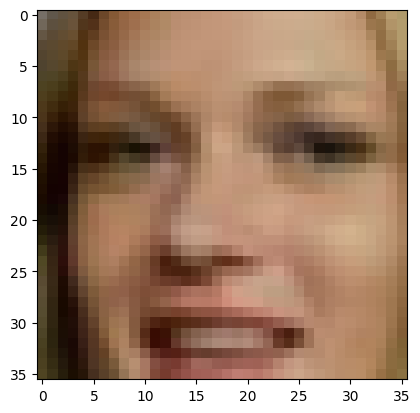

In [5]:
plt.imshow(data[0], cmap="gray", interpolation="none")

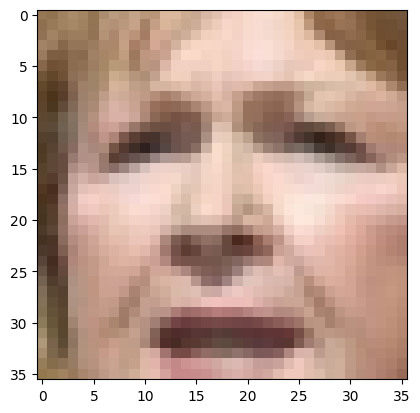

In [6]:
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

In [30]:
FULL_IMAGE_DIR = '/Users/Documents/workspacetf/GAN_Project/data/lfwmv'

BATCH_SIZE = 100
IMAGE_SHAPE = (36, 36, 3) # image shape 설정

data = tf.keras.utils.image_dataset_from_directory(
    FULL_IMAGE_DIR,
    labels=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SHAPE[:2], #이미지 불러올 때 사이즈 지정
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
#     interpolation='bilinear', #이미지 보간방법
)

Found 13233 files belonging to 1 classes.


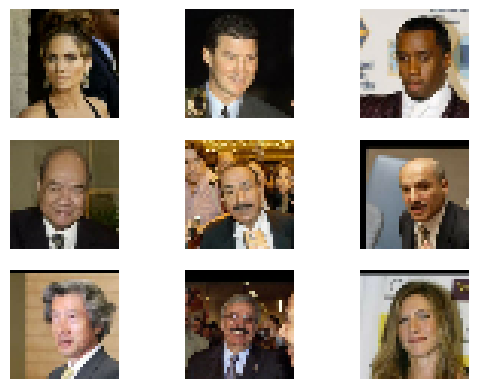

In [31]:
for images in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [32]:
def sample_images():
    tmp = data.repeat().take(1)
    tmp = list(tmp.as_numpy_iterator())
    tmp = np.array(tmp)
    tmp = tmp[0].astype("uint8")
    return tmp

In [74]:
data_arr = sample_images()

In [75]:
type(data_arr), data_arr[0].shape, data_arr.shape[0]

(numpy.ndarray, (36, 36, 3), 100)

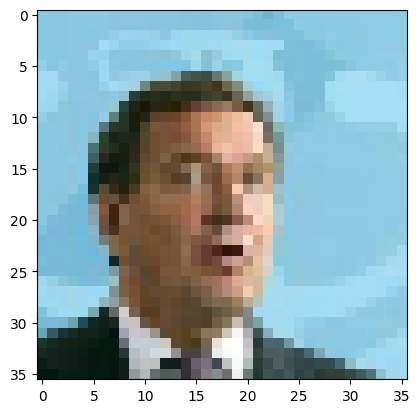

In [76]:
plt.imshow(data_arr[0], cmap="gray", interpolation="none")

Image shape : (36, 36, 3)
Total images: 13233


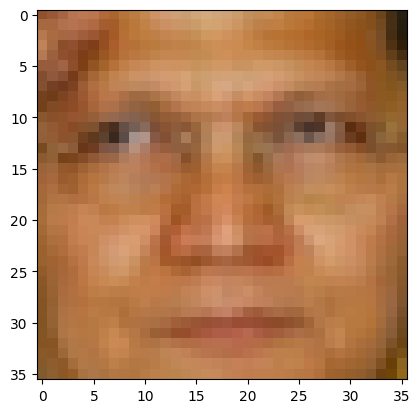

In [4]:
IMAGE_SHAPE = data.shape[1 : ]

print("Image shape :", IMAGE_SHAPE)
print("Total images:", len(data))
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

In [5]:
CODE_SIZE = 256

def generator():
  model = keras.Sequential()
  model.add(layers.Input(shape=(CODE_SIZE,), name='code'))
  model.add(layers.Dense(6*6*32, activation='elu'))
  model.add(layers.Reshape((6,6,32)))
  model.add(layers.Conv2DTranspose(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2DTranspose(128, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  model.add(layers.UpSampling2D())
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(3, kernel_size=3))
  return model


In [6]:
def discriminator():
  model = keras.Sequential()
  model.add(layers.Input(shape=IMAGE_SHAPE, name="image"))
  model.add(layers.Conv2D(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(32, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.MaxPool2D())
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=3, activation='elu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2()))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model


In [7]:
keras.backend.clear_session()

In [8]:
gen = generator()
gen.summary()
print("Inputs :", gen.inputs)
print("Outputs:", gen.outputs)

assert gen.output_shape[1:] == IMAGE_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMAGE_SHAPE,gen.output_shape[1:])

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              296064    
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      102528    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 12, 12, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       73792     
 ranspose)                                                       
                          

2023-03-07 23:47:01.505801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-07 23:47:01.505893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
disc = discriminator()

disc.summary()
print("Inputs :", disc.inputs)
print("Outputs:", disc.outputs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 34, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         204928    
                                                      

In [10]:
def create_discriminator_loss(g, d):
    return lambda images, codes: -tf.math.reduce_mean(
        tf.math.log( d(images) ) + tf.math.log( 1 - d(g(codes)) )
    )

def create_generator_loss(g, d):
    return lambda codes: -tf.math.reduce_mean(tf.math.log( d(g(codes)) ))

disc_opt = optimizers.SGD(1e-3)
disc_loss = create_discriminator_loss(gen, disc)

gen_opt = optimizers.Adam(1e-4)
gen_loss = create_generator_loss(gen, disc)

In [12]:
def sample_codes(batch_size):
    return np.float32(np.random.normal(size=(batch_size, CODE_SIZE)))

def sample_images(batch_size):
    return data[ np.random.choice(len(data), size=batch_size) ]

def plot_images(nrow, ncol):
    preds = gen.predict(sample_codes(nrow * ncol))

    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(preds[i].clip(0., 1.), interpolation="none")
        plt.axis("off")
    plt.show()

def plot_probas(size):
    plt.hist(disc.predict(sample_images(size)),
        range=(0, 1), alpha=0.5, label="D(x)"
    )
    plt.hist(disc.predict(gen.predict(sample_codes(size))),
        range=(0, 1), alpha=0.5, label="D(G(x))"
    )
    plt.legend()
    plt.show()

epoch = tf.Variable(0)

ckpt = tf.train.Checkpoint(epoch=epoch, disc=disc, gen=gen, disc_opt=disc_opt, gen_opt=gen_opt)
manager = tf.train.CheckpointManager(ckpt, directory="./checkpoints", max_to_keep=10)

status = ckpt.restore(manager.latest_checkpoint)

Epoch: 9900
1/1 [==============================] - 0s 18ms/step


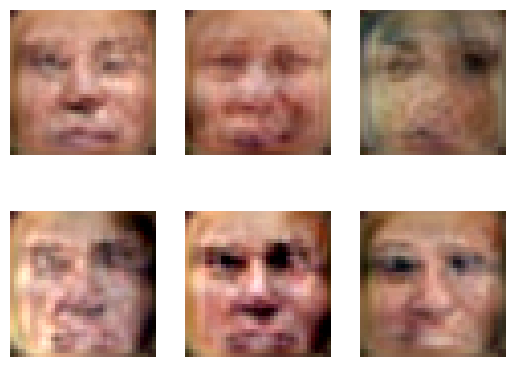

32/32 [==============================] - 1s 16ms/step


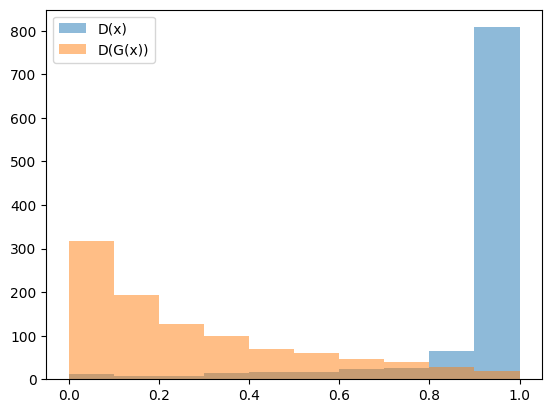

***************************************************************************************************.
CPU times: user 7h 35min 32s, sys: 1h 59min 1s, total: 9h 34min 34s
Wall time: 5h 40min 24s


In [14]:
%%time

for _ in progress(range(10000)): #30000 -> 10000
    codes = sample_codes(100)
    images = sample_images(100)

    for n in range(5):
        disc_opt.minimize(lambda: disc_loss(images, codes), disc.trainable_weights)

    gen_opt.minimize(lambda: gen_loss(codes), gen.trainable_weights)

    if epoch.numpy() % 100 == 0:
        display.clear_output(wait=True)

        print("Epoch:", epoch.numpy())
        plot_images(2, 3)
        plot_probas(1000)
        manager.save()

    epoch.assign_add(1)

Results after 10000 epochs:
4/4 [==============================] - 0s 28ms/step


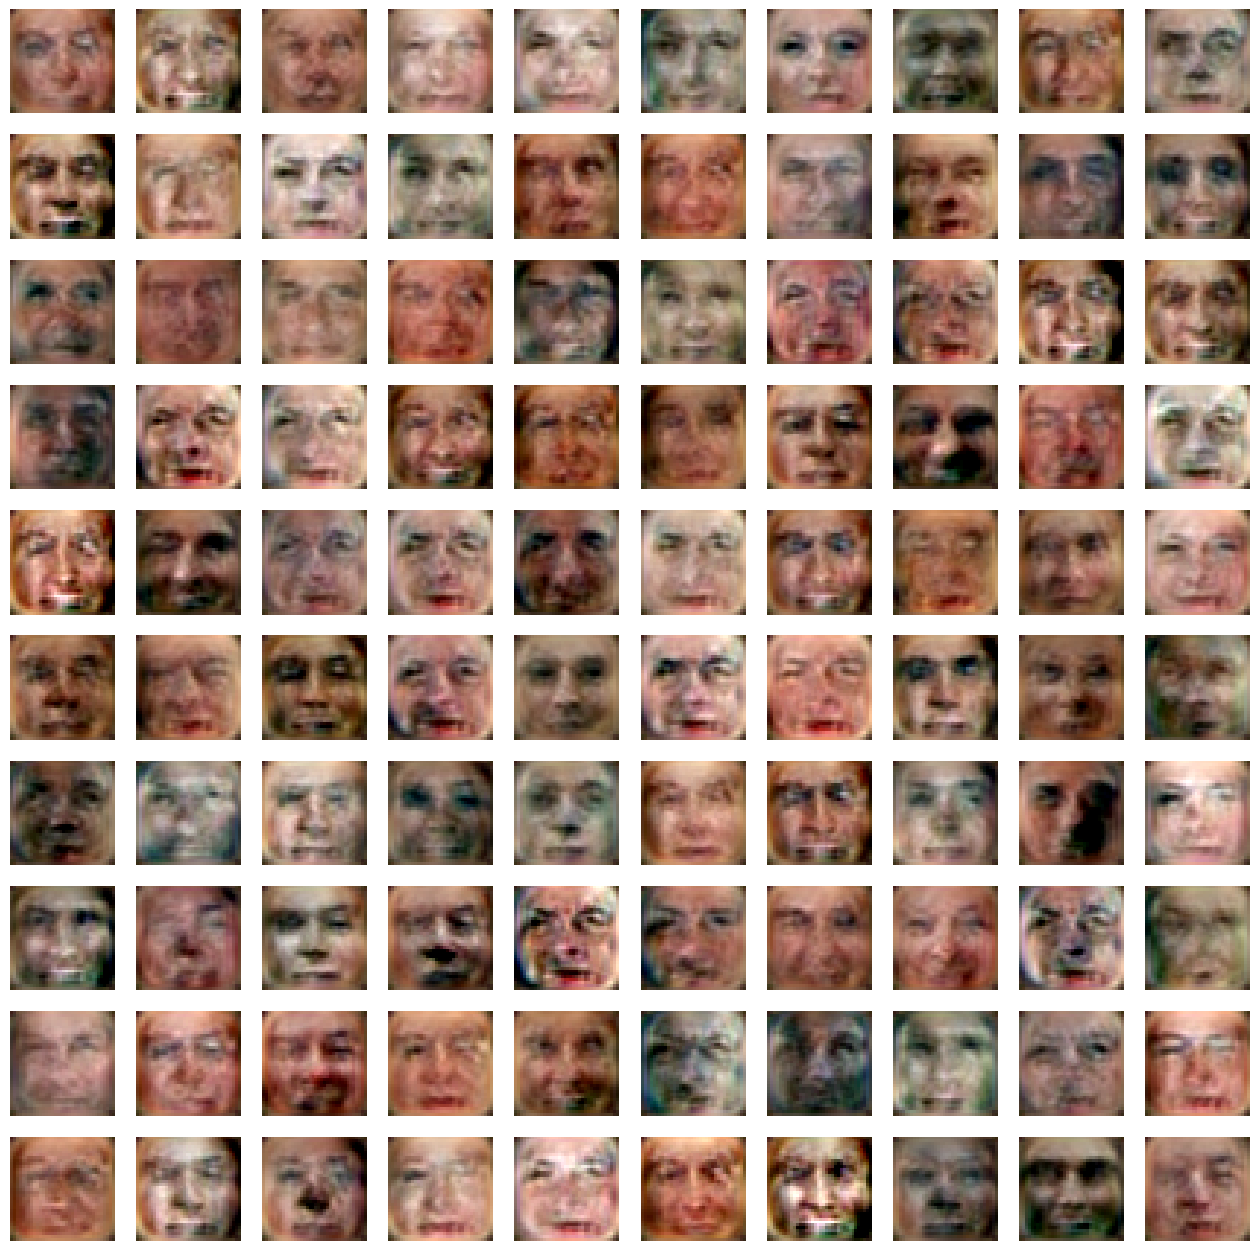

In [15]:
print("Results after", epoch.numpy(), "epochs:")
plt.figure(figsize=[16, 16])
plot_images(10, 10)